# Test Data Analysis of Housing Data

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

housing_db = pd.read_csv('housing.csv')
housing_db.info()
housing_db.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## Handle the null data with average
Fill them with the average of the column.
Optional Methods:
- Filling with average (won't change the overall)
- drop the empty rows
- use ml algoritms

In [2]:
housing_db_temp = housing_db.copy()
print(housing_db['total_bedrooms'].mean())
housing_db_temp.fillna(housing_db['total_bedrooms'].mean(), inplace = True)
housing_db_temp.isnull().sum()

537.8705525375618


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Plot the values

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

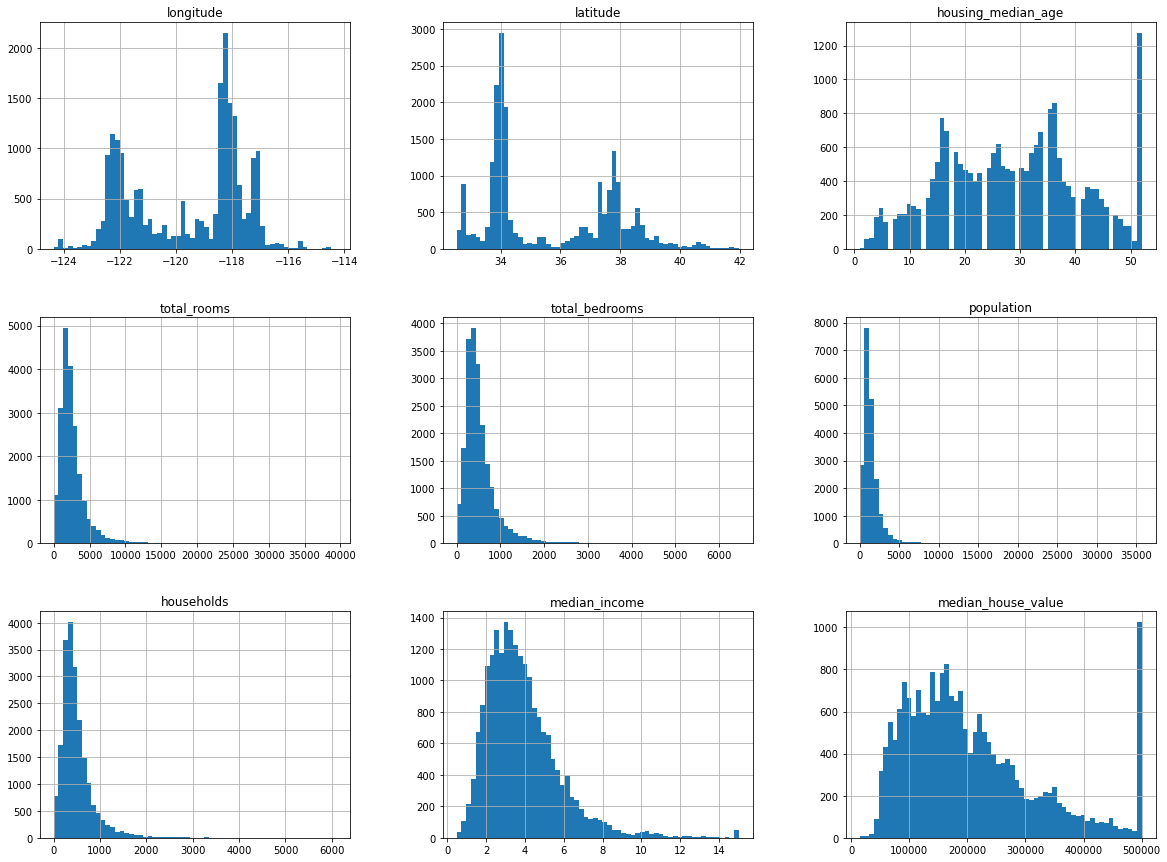

In [3]:
housing_db_temp.hist(bins = 60, figsize = (20,15))

## Change non-numerical data with suitable

In [4]:
print(housing_db_temp["ocean_proximity"].value_counts())
print(pd.get_dummies(housing_db_temp["ocean_proximity"]))
##Using 1 hot encoding
housing_db_onehot = pd.get_dummies(data = housing_db_temp, columns = ["ocean_proximity"])
##remove unwanted characters
housing_db_onehot.columns = [c.lower().replace(' ', '_').replace('<', '_') for c in housing_db_onehot.columns]
print(housing_db_onehot.head())

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64
       <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
0              0       0       0         1           0
1              0       0       0         1           0
2              0       0       0         1           0
3              0       0       0         1           0
4              0       0       0         1           0
...          ...     ...     ...       ...         ...
20635          0       1       0         0           0
20636          0       1       0         0           0
20637          0       1       0         0           0
20638          0       1       0         0           0
20639          0       1       0         0           0

[20640 rows x 5 columns]
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86           

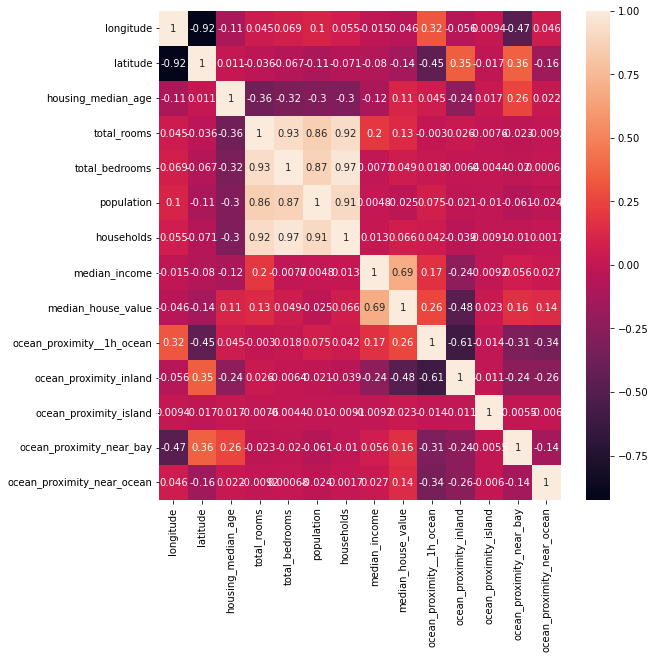

In [5]:
corroleation = housing_db_onehot.corr()
plt.figure(figsize = (9,9))
sns.heatmap(corroleation, annot = True)
plt.show()

## Corroleation Management
As we can see we have highly corroleated values such as population, household, rooms etc. They are corroleated because they have dependency each other. Thus, we can create new values according to the some equations of the independent values, and drop the corroleated ones.

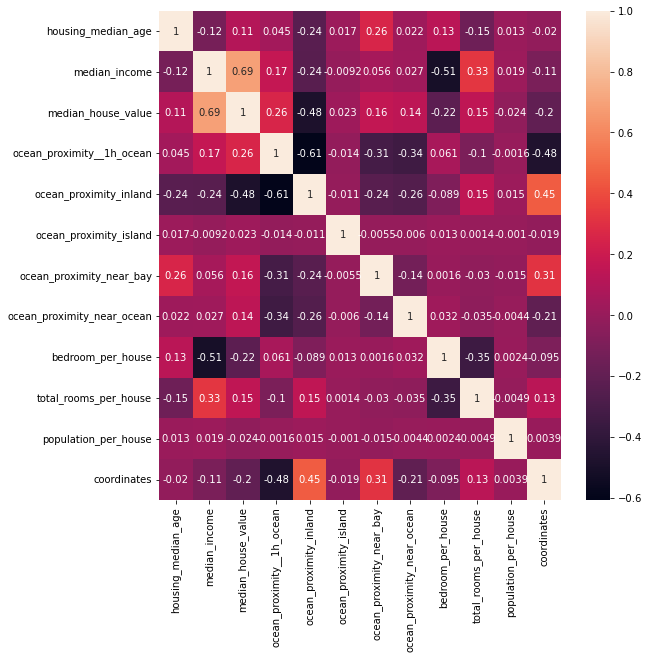

In [6]:
#add new dependents from corroleated ones.
housing_db_onehot["bedroom_per_house"] = housing_db_onehot["total_bedrooms"] / housing_db_onehot["total_rooms"]
housing_db_onehot["total_rooms_per_house"] = housing_db_onehot["total_rooms"] / housing_db_onehot["households"]
housing_db_onehot["population_per_house"] = housing_db_onehot["population"] / housing_db_onehot["households"]
housing_db_onehot["coordinates"] = housing_db_onehot["longitude"] / housing_db_onehot["latitude"]
#drop unwanted columns
housing_db_onehot = housing_db_onehot.drop("total_rooms", axis = 1)
housing_db_onehot = housing_db_onehot.drop("households", axis = 1)
housing_db_onehot = housing_db_onehot.drop("total_bedrooms", axis = 1)
housing_db_onehot = housing_db_onehot.drop("population", axis = 1)
housing_db_onehot = housing_db_onehot.drop("longitude", axis = 1)
housing_db_onehot = housing_db_onehot.drop("latitude", axis = 1)
#calculate new corroleation
corroleation = housing_db_onehot.corr()
plt.figure(figsize = (9,9))
sns.heatmap(corroleation, annot = True)
plt.show()

It's much better without any "too high" corroleations.

In [7]:
housing_db_onehot.to_csv('housing_reorganized.csv')

Split the data into train-test sets.

In [12]:
import sklearn
from sklearn.model_selection import train_test_split

valueAxis = housing_db_onehot[["housing_median_age", "median_income","bedroom_per_house","total_rooms_per_house","population_per_house","coordinates","ocean_proximity__1h_ocean",
                        "ocean_proximity_inland","ocean_proximity_island","ocean_proximity_near_bay","ocean_proximity_near_ocean"]]
predictionAxis = housing_db_onehot[["median_house_value"]]
#using the standard of 80% train, 20% test ratio.
valueTrain, valueTest, predictionTrain, predictionTest = train_test_split(valueAxis, predictionAxis,random_state=42, shuffle=True, test_size=0.2)

print(valueTrain.shape)
print(predictionTrain.shape)
print(valueTest.shape)
print(predictionTest.shape)

(16512, 11)
(16512, 1)
(4128, 11)
(4128, 1)


## Training the Model (Using XGBoost)
According to my studies about supervised machine learning for numerical values, xgboost is the most efficient one among other options.

In [13]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(valueTrain, predictionTrain)

ModuleNotFoundError: No module named 'xgboost'